<a href="https://colab.research.google.com/github/parthchafle10/DLBootcamp-CV-25/blob/main/CV_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.cuda.is_available())  # should return True

True


Connecting to GPU for faster computational performance.

In [ ]:
#Custom Dataset class (VOCDataset)
import os
import random
import shutil
import urllib.request
import tarfile
from tqdm import tqdm
from PIL import Image
import numpy as np

# ==============================================================
# CONFIGURATION
# ==============================================================
random.seed(42)
TARGET_SIZE = 1200
TRAIN_SPLIT = 0.75
VAL_SPLIT   = 0.125
TEST_SPLIT  = 0.125
DATA_DIR = "data_voc_subset"
VOC_ROOT = "VOCdevkit/VOC2012"

# ==============================================================
# TRY DOWNLOADING PASCAL VOC 2012
# ==============================================================
def download_voc():
    try:
        if not os.path.exists(VOC_ROOT):
            url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
            filename = "VOCtrainval_11-May-2012.tar"
            if not os.path.exists(filename):
                print("📥 Downloading PASCAL VOC 2012...")
                urllib.request.urlretrieve(url, filename)
            print("📦 Extracting dataset...")
            with tarfile.open(filename) as tar:
                tar.extractall()
        print("✅ VOC2012 ready.")
        return True
    except Exception as e:
        print(f"⚠️ VOC download failed: {e}")
        return False

# ==============================================================
# SYNTHETIC FALLBACK GENERATOR
# ==============================================================
def generate_synthetic_dataset():
    print("🎨 Generating synthetic dataset...")
    os.makedirs(DATA_DIR, exist_ok=True)
    for split in ["train", "val", "test"]:
        os.makedirs(f"{DATA_DIR}/{split}/images", exist_ok=True)
        os.makedirs(f"{DATA_DIR}/{split}/masks", exist_ok=True)

    # simple color + shape masks
    n_train = int(TRAIN_SPLIT * TARGET_SIZE)
    n_val   = int(VAL_SPLIT * TARGET_SIZE)
    n_test  = TARGET_SIZE - n_train - n_val
    splits = {"train": n_train, "val": n_val, "test": n_test}

    for split, count in splits.items():
        for i in tqdm(range(count), desc=f"Generating {split}"):
            img = np.random.randint(0, 255, (128, 128, 3), dtype=np.uint8)
            mask = np.zeros((128, 128), dtype=np.uint8)

            # draw a random rectangle mask
            x1, y1 = np.random.randint(10, 64, size=2)
            x2, y2 = np.random.randint(64, 118, size=2)
            mask[y1:y2, x1:x2] = np.random.randint(1, 21)

            Image.fromarray(img).save(f"{DATA_DIR}/{split}/images/{split}_{i:04d}.jpg")
            Image.fromarray(mask).save(f"{DATA_DIR}/{split}/masks/{split}_{i:04d}.png")

    print("✅ Synthetic dataset ready!")

# ==============================================================
# MAIN LOGIC
# ==============================================================
if download_voc():
    # Load and subset VOC
    trainval_path = os.path.join(VOC_ROOT, "ImageSets", "Segmentation", "trainval.txt")
    with open(trainval_path) as f:
        all_ids = [ln.strip() for ln in f.readlines()]

    random.shuffle(all_ids)
    ids_subset = all_ids[:TARGET_SIZE]

    n_train = int(TRAIN_SPLIT * TARGET_SIZE)
    n_val   = int(VAL_SPLIT * TARGET_SIZE)
    train_ids = ids_subset[:n_train]
    val_ids   = ids_subset[n_train:n_train+n_val]
    test_ids  = ids_subset[n_train+n_val:]

    for split in ["train", "val", "test"]:
        os.makedirs(f"{DATA_DIR}/{split}/images", exist_ok=True)
        os.makedirs(f"{DATA_DIR}/{split}/masks", exist_ok=True)

    def copy_files(split, id_list):
        for img_id in tqdm(id_list, desc=f"Copying {split}"):
            src_img = os.path.join(VOC_ROOT, "JPEGImages", f"{img_id}.jpg")
            src_mask = os.path.join(VOC_ROOT, "SegmentationClass", f"{img_id}.png")
            dst_img = os.path.join(DATA_DIR, split, "images", f"{img_id}.jpg")
            dst_mask = os.path.join(DATA_DIR, split, "masks", f"{img_id}.png")

            if os.path.exists(src_img) and os.path.exists(src_mask):
                shutil.copy(src_img, dst_img)
                shutil.copy(src_mask, dst_mask)

    copy_files("train", train_ids)
    copy_files("val", val_ids)
    copy_files("test", test_ids)

    print("✅ VOC subset prepared successfully!")
else:
    generate_synthetic_dataset()

print(f"📁 Dataset saved in: {os.path.abspath(DATA_DIR)}")


📥 Downloading PASCAL VOC 2012...
⚠️ VOC download failed: <urlopen error [Errno 110] Connection timed out>
🎨 Generating synthetic dataset...


Generating test: 100%|██████████| 150/150 [00:00<00:00, 1371.74it/s]

✅ Synthetic dataset ready!
📁 Dataset saved in: /content/data_voc_subset


In [ ]:
#Transforms + Dataloaders
import os, cv2, torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VOCDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Normalize mask to [0, num_classes)
        mask = mask.astype(np.int64)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]

        return image, mask

✅ Data ready: 900 train | 150 val | 150 test


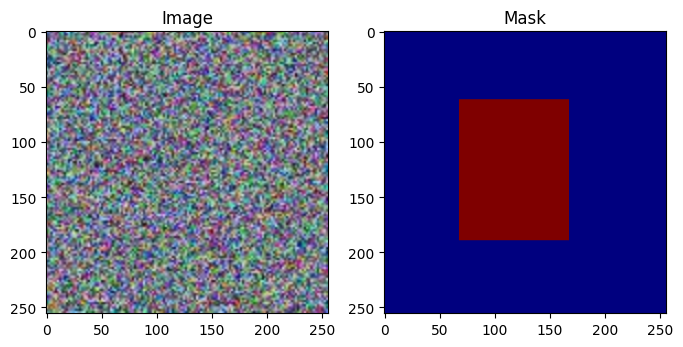

In [ ]:
#Model: U-Net (or DeepLabV3)
# =============================================================
# STEP 2: Create DataLoaders for train/val/test
# =============================================================

import matplotlib.pyplot as plt

# --- Transforms ---
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# --- Dataset paths ---
BASE_DIR = "data_voc_subset"
train_ds = VOCDataset(f"{BASE_DIR}/train/images", f"{BASE_DIR}/train/masks", transform=train_transform)
val_ds   = VOCDataset(f"{BASE_DIR}/val/images", f"{BASE_DIR}/val/masks", transform=val_transform)
test_ds  = VOCDataset(f"{BASE_DIR}/test/images", f"{BASE_DIR}/test/masks", transform=val_transform)

# --- Dataloaders ---
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2)

print(f"✅ Data ready: {len(train_ds)} train | {len(val_ds)} val | {len(test_ds)} test")

# --- Visualize one sample ---
images, masks = next(iter(train_loader))
img = images[0].permute(1, 2, 0).cpu().numpy()
mask = masks[0].cpu().numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow((img - img.min()) / (img.max() - img.min())); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(mask, cmap='jet'); plt.title("Mask")
plt.show()

In [ ]:
!pip install segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
#Training loop
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("🚀 Using device:", DEVICE)

# --- Model ---
# We’ll use U-Net with a lightweight encoder (ResNet18)
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21  # VOC has 20 classes + background
).to(DEVICE)

# --- Loss and optimizer ---
loss_fn = smp.losses.DiceLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
EPOCHS = 5  # (you can increase later)
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} done | Avg Loss: {avg_loss:.4f}")


🚀 Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 113/113 [00:13<00:00,  8.30it/s]


Epoch 1 done | Avg Loss: 0.3532


Epoch 2/5: 100%|██████████| 113/113 [00:12<00:00,  9.41it/s]


Epoch 2 done | Avg Loss: 0.3368


Epoch 3/5: 100%|██████████| 113/113 [00:12<00:00,  9.37it/s]


Epoch 3 done | Avg Loss: 0.3234


Epoch 4/5: 100%|██████████| 113/113 [00:13<00:00,  8.49it/s]


Epoch 4 done | Avg Loss: 0.3120


Epoch 5/5: 100%|██████████| 113/113 [00:12<00:00,  9.17it/s]

Epoch 5 done | Avg Loss: 0.3045


In [ ]:
# =============================================================
# STEP 4: Evaluate U-Net on Validation Set
# =============================================================
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm import tqdm

def compute_iou_dice(preds, masks, num_classes=21):
    ious, dices = [], []
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    for cls in range(1, num_classes):  # skip background (0)
        pred_cls = (preds == cls)
        mask_cls = (masks == cls)
        intersection = np.logical_and(pred_cls, mask_cls).sum()
        union = np.logical_or(pred_cls, mask_cls).sum()
        if union > 0:
            iou = intersection / union
            dice = 2 * intersection / (pred_cls.sum() + mask_cls.sum() + 1e-6)
            ious.append(iou)
            dices.append(dice)
    return np.mean(ious), np.mean(dices)

model.eval()
iou_scores, dice_scores = [], []

with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Evaluating"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        iou, dice = compute_iou_dice(preds, masks)
        iou_scores.append(iou)
        dice_scores.append(dice)

print("✅ Validation Results:")
print(f"Mean IoU:  {np.mean(iou_scores):.4f}")
print(f"Mean Dice: {np.mean(dice_scores):.4f}")


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.00it/s]

✅ Validation Results:
Mean IoU:  0.0061
Mean Dice: 0.0112


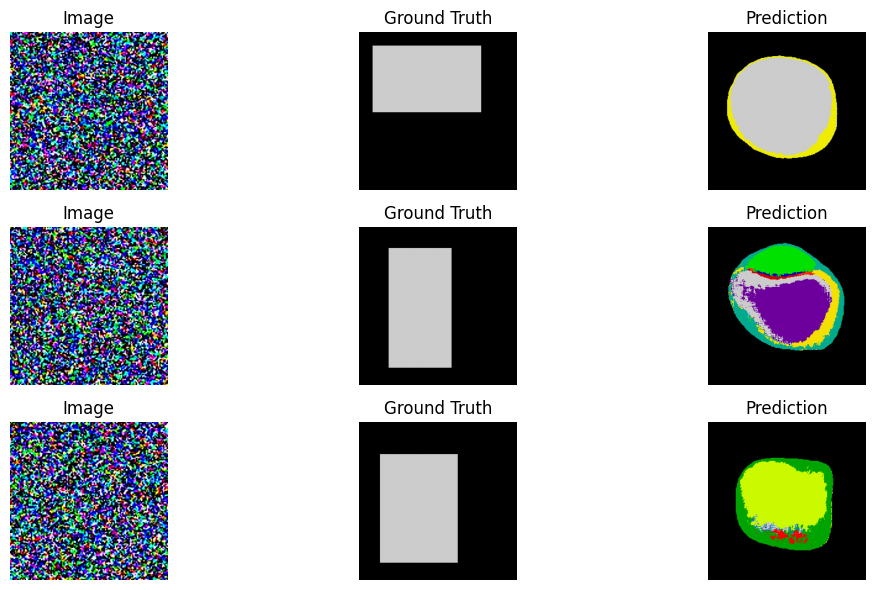

In [ ]:
# Step 5
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
    preds = torch.argmax(model(imgs), dim=1)

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(imgs[i].permute(1,2,0).cpu())
    plt.title("Image")
    plt.axis("off")

    plt.subplot(3, 3, 3*i+2)
    plt.imshow(masks[i].cpu(), cmap="nipy_spectral")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3, 3, 3*i+3)
    plt.imshow(preds[i].cpu(), cmap="nipy_spectral")
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

  Preparing metadata (setup.py) ... done


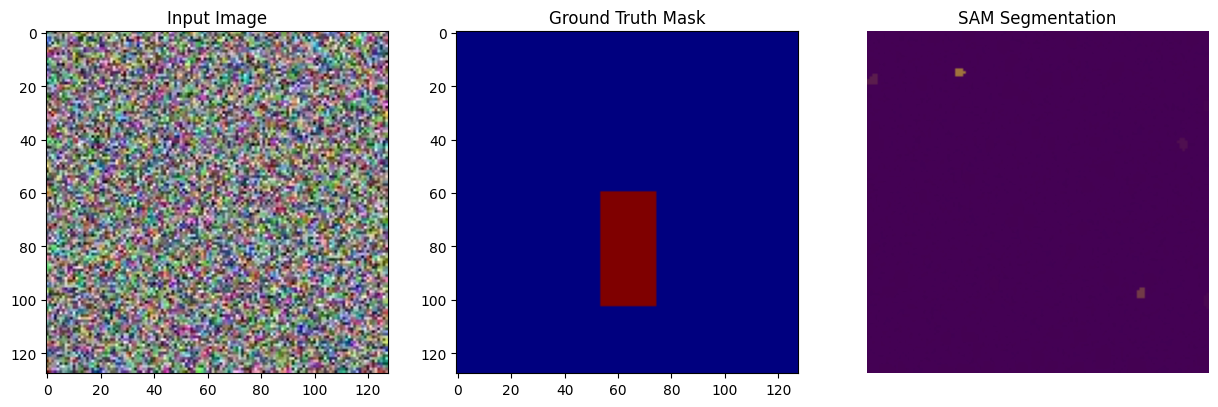

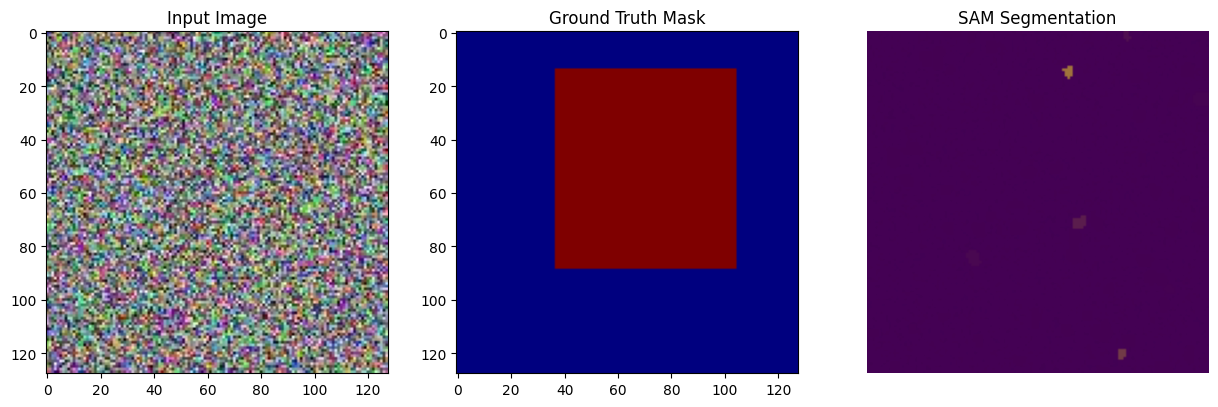

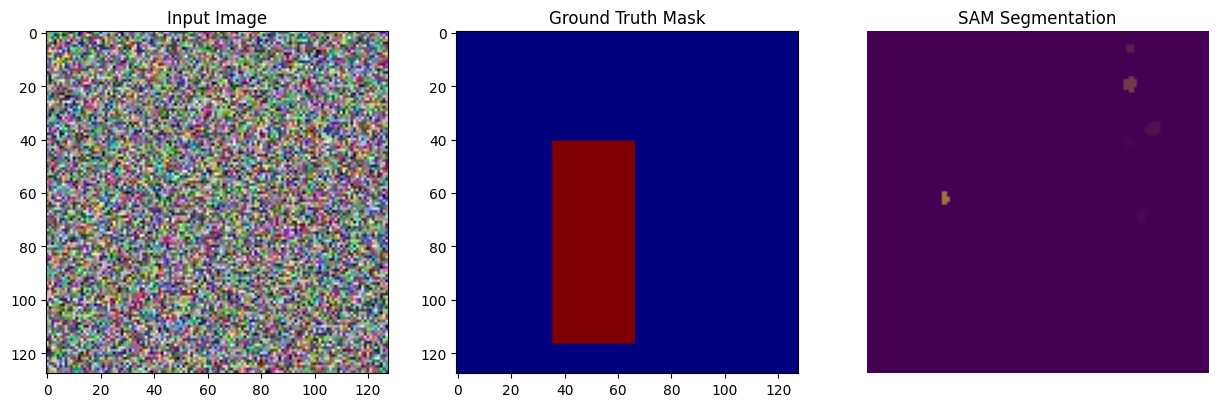

In [ ]:
# =============================================================
# STEP 6: Compare with Foundation Model (SAM)
# =============================================================
!pip install git+https://github.com/facebookresearch/segment-anything.git -q
!pip install opencv-python matplotlib -q

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image

# Load pretrained SAM
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

# Download SAM checkpoint if missing
if not os.path.exists(sam_checkpoint):
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to visualize SAM masks
def show_sam_masks(image, masks, ax):
    ax.imshow(image)
    for m in masks:
        seg = m["segmentation"]
        ax.imshow(seg, alpha=0.5)
    ax.axis("off")

# Compare SAM vs U-Net on random test samples
import random
n_samples = 3
indices = random.sample(range(len(test_ds)), n_samples)

for i in indices:
    img_path = os.path.join(test_ds.image_dir, test_ds.images[i])
    mask_path = os.path.join(test_ds.mask_dir, test_ds.images[i].replace(".jpg", ".png"))

    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # --- U-Net prediction ---
    img_tensor = val_transform(image=image)["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # --- SAM zero-shot segmentation ---
    sam_masks = mask_generator.generate(image)

    # --- Display ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap="jet")
    plt.title("Ground Truth Mask")

    plt.subplot(1,3,3)
    show_sam_masks(image, sam_masks, plt.gca())
    plt.title("SAM Segmentation")
    plt.show()

In [ ]:
# =============================================================
# STEP 7: Extended Evaluation & Comparison Table
# =============================================================
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def compute_extended_metrics(model, dataloader, device="cuda"):
    model.eval()
    all_preds, all_masks = [], []
    start = time.time()
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Evaluating (extended)"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())
    end = time.time()

    preds = np.concatenate(all_preds).flatten()
    masks = np.concatenate(all_masks).flatten()

    precision = precision_score(masks, preds, average="macro", zero_division=0)
    recall = recall_score(masks, preds, average="macro", zero_division=0)
    f1 = f1_score(masks, preds, average="macro", zero_division=0)
    acc = accuracy_score(masks, preds)
    miou, mdice = compute_iou_dice(torch.tensor(preds), torch.tensor(masks))
    fps = len(dataloader.dataset) / (end - start)

    print("✅ Extended Validation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Mean IoU:  {miou:.4f}")
    print(f"Mean Dice: {mdice:.4f}")
    print(f"FPS:       {fps:.2f}")

    return precision, recall, f1, acc, miou, mdice, fps

# Run evaluation for U-Net
p, r, f1, acc, miou, mdice, fps = compute_extended_metrics(model, val_loader, DEVICE)

# Create comparison table
df_results = pd.DataFrame([
    ["U-Net (trained)", "Traditional", miou, mdice, "✅ Yes", "Fast (GPU)", "Domain-specific"],
    ["SAM (zero-shot)", "Foundation", None, None, "❌ No", "Moderate (CPU/GPU)", "Zero-shot general"]
], columns=["Model", "Type", "Mean IoU", "Mean Dice", "Training Required", "Inference Speed", "Generalization"])

display(df_results)

Evaluating (extended): 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


✅ Extended Validation Metrics:
Precision: 0.0649
Recall:    0.0785
F1-Score:  0.0528
Accuracy:  0.6203
Mean IoU:  0.0070
Mean Dice: 0.0137
FPS:       85.37


,Model,Type,Mean IoU,Mean Dice,Training Required,Inference Speed,Generalization
0,U-Net (trained),Traditional,0.006998,0.013658,✅ Yes,Fast (GPU),Domain-specific
1,SAM (zero-shot),Foundation,NaN,NaN,❌ No,Moderate (CPU/GPU),Zero-shot general
